In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15 # number of steps to backpropagate through time
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
%matplotlib notebook

### Generate Training Data
* Here we are just making random binary vectors.
* Our "label" (i.e. the output) will be an echo of the input, shifted `echo_steps` to the right.
* Notice the reshaping of the data into a matrix with `batch_size` rows.

In [2]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step) # roll by echo_step places to create our "echo" data
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))

    return (x, y)

### Multilayer LSTM Networks

* For each layer of the network, we'll need a hidden state, and a cell state.
* Normally, the input to the next LSTM layer is the previous state for that particular layer as well as the hidden activations of the "lower" layer that it is stacked on top of.

<table><tr><td><img src='../pics/deep_RNN.png' style="width: 300px"></td><td><img src='../pics/LSTM_2layer.png' style="width: 600px"></td></td></tr></table>

In [3]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

# Now we are putting everything in one graph so we replace this ... :
#cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
#hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
#init_state = tf.nn.rnn_cell.LSTMStateTuple(cell_state, hidden_state)

# With this:
num_layers = 3
init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

* We want to split the batch data into adjacent time-steps
* We do this by unstacking the columns (`axis=1`) into a Python list
* This will allow the RNN to simultaneously train on different parts of the time series.
* Note that we are using the convention `VARIABLENAME_series` to emphasize that the variable is a list representing a timeseries with multiple samples at each step.
* Because training is being done simultaneously on `batch_size` different places in our time-series, this requires us to save `batch_size` number of instances of RNN states when propagating forward. 
* You can see that we are accounting for this as the `init_state` placeholder has `batch_size` number of rows.

### Forward Pass
* Notice in the `tf.concat` operation we use to create `input_and_state_concatenated`, what we actually want to do is calculate the sum of two affine transformations:
    * `current_input * Wa` and
    * `current_state * Wb
* By combining these two resulting tensors, this allows us to use only one matrix multiplication. 
* Then the bias `b` is broadcast on all samples in the batch
<img src='../pics/RNN_no_frills_forward_pass.png'>

### New Forward Pass for Multilayer LSTM
* Since the TensorFlow Multilayer-LSTM-API accepts the state as a tuple of LSTMTuples, we need to unpack the state into this structure. 
* For each layer in the state we create a `LSTMTuple`, and put these in a tuple, as shown below. 
* All this is added in just after the `init_state` placeholder.
* Note that as we are now making a stacked RNN, we should not reuse the same cell for the first and the deeper layers as their inputs ar different (and thus kernel matrices are different).
* So we create an extra `make_lstm_cell` function to create a new and different cell for each layer.

In [4]:
# Unstack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
#cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
#states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

# Forward passes
def make_lstm_cell(state_size):
    return tf.contrib.rnn.LSTMCell(state_size, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([make_lstm_cell(state_size) for _ in range(num_layers)], state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, initial_state=rnn_tuple_state)

#### Side note: Why do we use `tf.tanh()` as our activation function, and not ReLU?
* RNNs manage an internal state vector whose values should be able to increase or decrease when we add the output of some function. 
* The output from tanh can be positive or negative, allowing for increases and decreases in the state.

### Calculating loss
* This is the final part of the graph: a fully connected softmax layer from the state to the output that will make the classes one-hot encoded. 
* We then calculate the loss of the batch.
* `sparse_softmax_cross_entropy_with_logits` automatically calculates the softmax internaly and then computes the cross-entropy. 
* In this example, our classes are mutually exclusive (they are either `0` or `1`), thus we use **sparse** softmax.
* The logits should be of shape `[batchsize, num_classes]` and the labels of shape `[batch_size]`.

In [5]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

#### Side note: What is `truncated_backprop_length` ???
* When a RNN is trained, it is actually treated as a deep neural network with reoccurring weights in every layer. 
* These layers will not be unrolled to the beginning of time as that would be too computationally expensive.
* Therefore, the layers are truncated at a limited number of time-steps. In the diagram above, the error is backpropagated three steps in our batch.

### Saving

In [6]:
saver = tf.train.Saver()
save_dir = 'logs/RNN_checkpoints'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')

### Visualization

In [7]:
def plot_results(loss_list, predictions_series, batchX, batchY,dynamic=False):
    plt.subplot(2, 3, 1)
    if dynamic:
        plt.gca()
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    if dynamic:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.pause(0.0001)

### LSTM state is different than in a basic RNN
* LSTMs have both a "cell state" and a "hidden state, so now instead of just having a `_current_state` variable, we split this into `_current_cell_state` and `_current_hidden_state`
* Since the `current_state` returns the cell- and hidden states in a tuple, they should be separated after calculation and supplied to the placeholders in the `run`-function. Thus, in the feed_dict, we have replaced `init_state` with `cell_state` and `hidden_state`.
* The network's state is now stored in a single tensor, so we can modify our run function from this:
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state
                    }

* To this:
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state: _current_state
                    }

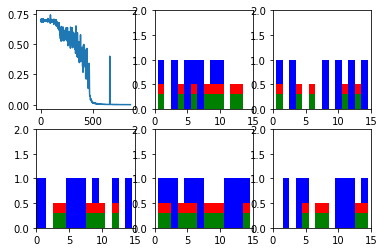

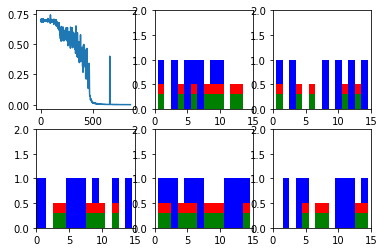

Step 200 Loss 0.0016818569
Step 200 Loss 0.0016818569
Step 200 Loss 0.0016818569


KeyboardInterrupt: 

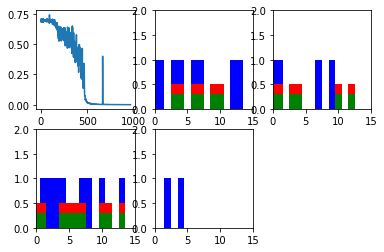

In [8]:
dynamic_plotting = False

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        #_current_cell_state = np.zeros((batch_size, state_size))
        #_current_hidden_state = np.zeros((batch_size, state_size))
        
        _current_state = np.zeros((num_layers, 2, batch_size, state_size))
       
        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state: _current_state
                })
            
            loss_list.append(_total_loss)

            if batch_idx%300 == 0:
                if dynamic_plotting:
                    plot_results(loss_list, _predictions_series, batchX, batchY,dynamic=True)
                    print("Step",batch_idx, "Loss", _total_loss)    
                    print("Step",batch_idx, "Loss", _total_loss)
                    print("Step",batch_idx, "Loss", _total_loss)
                    print("Step",batch_idx, "Loss", _total_loss)
                else:
                    print("Step",batch_idx, "Loss", _total_loss)

In [ ]:
if not dynamic_plotting:
    plot_results(loss_list, _predictions_series, batchX, batchY,dynamic=True)